
This project is centered around the classification of dermoscopic images into two categories: melanoma and benign lesions. The dataset used for training and evaluation is sourced from the Kaggle platform [https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data]. 
The primary goal of this project is to develop a model capable of accurately distinguishing between malignant (melanoma) and benign skin lesions, contributing to the early detection and diagnosis of skin cancer.

In [1]:
import os
import numpy as np
import imageio.v2 as imageio
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.applications.efficientnet import preprocess_input

Function to load image data from a specified directory

In [2]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = imageio.imread(img_path)
            images.append(image)
    return images


This code defines the parameters for loading and processing images. It sets the target image width and height to 224x224 pixels and specifies a batch size of 32 for training. Additionally, it defines the paths to the folders where the training and test images are stored. The train_folder points to the location of the training images, while the test_folder points to the location of the test images.

In [3]:

img_width, img_height = 224, 224
batch_size = 32


train_folder = r"C:\projekt ML\train" #replace with your own path
test_folder = r"C:\projekt ML\test" #replace with your own path



Data Preprocessing and Augmentation
To prepare the data for training, validation, and testing, the ImageDataGenerator class from Keras was utilized to rescale pixel values and apply various transformations. This approach ensures improved model generalization by exposing the model to a diverse range of variations during training. The key steps include:

Training Data Augmentation:

A train_datagen object was created with multiple transformations such as:
Rescaling pixel values to the range [0, 1] by dividing by 255.
Random rotations (up to 20 degrees).
Shifts in both width and height (up to 20%).
Random shearing, zooming, and brightness adjustments.
Horizontal flipping of images.
Filling any gaps created by transformations using the nearest pixel method.
The augmented training data is generated from the dataset using the flow_from_directory method, which organizes images into batches and ensures consistency with the specified target image size and batch size.

Validation Data Preprocessing:

The validation_datagen object includes only basic rescaling to normalize pixel values.
A 30% subset of the training dataset is reserved for validation using the validation_split parameter.

Test Data Preprocessing:

For the test dataset, no augmentations are applied to preserve data integrity during evaluation. The test_datagen object rescaled pixel values similarly to the training and validation datasets.

Conversion to TensorFlow Datasets:

The flow_from_directory generators for training, validation, and test datasets were wrapped using a custom generator function to enable compatibility with TensorFlow’s tf.data.Dataset API.
This allowed for:
Efficient pipeline creation using the from_generator method.
Specification of input (tf.TensorSpec) shapes and types for consistency.
Seamless iteration over the data during training and evaluation.

Repeat for Continuous Data Feeds:

The training and validation datasets were configured with .repeat() to provide continuous data feeds for training loops, which is particularly useful for cases with multiple epochs.

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.3)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=123
)
validation_generator = validation_datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=123
)
def generator_wrapper(generator):
    for data in generator:
        yield data

train_dataset = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(validation_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(test_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, img_width, img_height, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

Found 11879 images belonging to 2 classes.
Found 3563 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Model Architecture and Fine-Tuning
This step involves constructing a convolutional neural network (CNN) for binary classification by leveraging a pre-trained VGG16 model as the base. The architecture is augmented with additional layers tailored to the task at hand. Key details are as follows:

Base Model:

The pre-trained VGG16 model, trained on the ImageNet dataset, is loaded without the fully connected (top) layers.
Input dimensions are set to (224, 224, 3) to match the required input format.
Freezing Layers:
All layers of the base model are frozen to retain pre-trained weights.
The last four layers are unfrozen to allow fine-tuning, enabling the model to adapt to the specific dataset.

Custom Head (Additional Layers):

The output of the VGG16 base model is passed to a custom layer stack to enhance feature extraction and classification:
Convolutional Layers:
A 128-filter Conv2D layer with a 3x3 kernel and ReLU activation, followed by batch normalization, is added.
A second 64-filter Conv2D layer with the same specifications is applied, also followed by batch normalization.
Global Average Pooling:
A GlobalAveragePooling2D layer reduces the spatial dimensions to a single feature vector for each filter.
Dense Layers with Dropout:
Three fully connected (Dense) layers with 256, 128, and 64 units respectively are added.
Each Dense layer uses ReLU activation, is followed by batch normalization, and includes a Dropout layer with a rate of 0.5 to reduce overfitting.
Output Layer:
A single neuron with a sigmoid activation is used for binary classification.

Model Compilation:

The model is compiled with:
Optimizer: Adam optimizer with a learning rate of 0.0001.
Loss Function: Binary Crossentropy, suitable for binary classification tasks.
Metrics: Accuracy, to monitor model performance.
Learning Rate Scheduling and Early Stopping:

Two callbacks are configured:
ReduceLROnPlateau: Monitors validation loss and reduces the learning rate by a factor of 0.5 if the metric does not improve for 3 consecutive epochs. The minimum learning rate is capped at 1e-7.
EarlyStopping: Monitors validation loss, halting training if it does not improve for 5 epochs and restoring the best model weights.
Summary of the Model:

The model.summary() method is used to display the architecture, showing the number of parameters in each layer and the total trainable/non-trainable parameters.
This architecture combines the power of transfer learning with task-specific layers, enabling efficient training and robust performance on the given dataset while minimizing the risk of overfitting.

In [ ]:

from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

img_width, img_height = 224, 224


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


base_model.trainable = False
for layer in base_model.layers[-4
                               :]:
    layer.trainable = True


x = base_model.output  
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)


x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x) 


x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)  


x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)  



predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer = Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])






model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             

 Total params: 15,438,849 (58.89 MB)

 Trainable params: 7,802,305 (29.76 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

Model Training

The model is trained using the fit method in TensorFlow/Keras, which involves feeding the training and validation datasets into the model over a specified number of epochs. The process includes monitoring performance metrics and implementing callbacks for dynamic learning rate adjustment and early stopping. Key details are as follows:

Training Setup:

The training dataset is provided as a train_dataset TensorFlow Dataset object, created from an augmented and preprocessed generator.
The validation dataset (validation_dataset) is used to evaluate model performance after each epoch.

Steps per Epoch:

steps_per_epoch is calculated as the total number of training samples divided by the batch size, ensuring the model processes the entire dataset in each epoch.
Similarly, validation_steps ensures that the entire validation set is evaluated during each epoch.
Number of Epochs:

The model is set to train for a maximum of 15 epochs, which balances sufficient training with the prevention of overfitting or unnecessary computation.

Callbacks:

ReduceLROnPlateau:
Dynamically adjusts the learning rate by reducing it by a factor of 0.5 if the validation loss does not improve for 3 consecutive epochs.
Prevents the optimizer from being stuck in a local minimum by slowing down the learning process.

EarlyStopping:
Halts training if validation loss does not improve for 5 epochs.
Restores the best model weights from the epoch with the lowest validation loss, ensuring optimal performance.

Execution:

The model.fit() function initiates the training process, with the datasets fed iteratively for the specified epochs or until an early stopping condition is met.
This step trains the model by optimizing its parameters to minimize the binary cross-entropy loss while ensuring robust generalization through validation monitoring and adaptive learning rate control.

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // batch_size,
   

    epochs=15,  


    callbacks=[reduce_lr, early_stopping, ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')],  
  
)


Epoch 1/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1490s 4s/step - accuracy: 0.6405 - loss: 0.7401 - val_accuracy: 0.7590 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 2/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1419s 4s/step - accuracy: 0.7871 - loss: 0.4815 - val_accuracy: 0.8238 - val_loss: 0.4230 - learning_rate: 1.0000e-04
Epoch 3/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1505s 4s/step - accuracy: 0.8158 - loss: 0.4262 - val_accuracy: 0.8187 - val_loss: 0.4065 - learning_rate: 1.0000e-04
Epoch 4/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1467s 4s/step - accuracy: 0.8298 - loss: 0.4007 - val_accuracy: 0.7686 - val_loss: 0.5366 - learning_rate: 1.0000e-04
Epoch 5/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1442s 4s/step - accuracy: 0.8227 - loss: 0.3938 - val_accuracy: 0.8238 - val_loss: 0.4000 - learning_rate: 1.0000e-04
Epoch 6/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1508s 4s/step - accuracy: 0.8436 - loss: 0.3477 - val_accuracy: 0.8451 - val_loss: 0.3468 - learning_rate: 1.0000e-04
Epoch 7/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1482s 4s/ste

Model Fine-Tuning (Additional Training)
After the initial training, the model is fine-tuned with an additional 15 epochs to further improve performance and leverage the saved model from the previous training. This step also introduces a ModelCheckpoint callback to save the best-performing model based on validation loss. 

This fine-tuning phase ensures the model achieves optimal performance by continuing training from its previous state and saving the best configuration for deployment. The use of callbacks allows for dynamic adjustments and ensures the best model is preserved.

In [7]:
history2 = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // batch_size,
    epochs=15, 
    callbacks=[reduce_lr, early_stopping, ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]
)

Epoch 1/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1426s 4s/step - accuracy: 0.8803 - loss: 0.2769 - val_accuracy: 0.8318 - val_loss: 0.3685 - learning_rate: 5.0000e-05
Epoch 2/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1412s 4s/step - accuracy: 0.8804 - loss: 0.2685 - val_accuracy: 0.8440 - val_loss: 0.3120 - learning_rate: 5.0000e-05
Epoch 3/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1414s 4s/step - accuracy: 0.8866 - loss: 0.2692 - val_accuracy: 0.8842 - val_loss: 0.2548 - learning_rate: 5.0000e-05
Epoch 4/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1437s 4s/step - accuracy: 0.8810 - loss: 0.2773 - val_accuracy: 0.8632 - val_loss: 0.2952 - learning_rate: 5.0000e-05
Epoch 5/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1460s 4s/step - accuracy: 0.8878 - loss: 0.2650 - val_accuracy: 0.9017 - val_loss: 0.2356 - learning_rate: 5.0000e-05
Epoch 6/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1456s 4s/step - accuracy: 0.8870 - loss: 0.2685 - val_accuracy: 0.8978 - val_loss: 0.2381 - learning_rate: 5.0000e-05
Epoch 7/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 1470s 4s/ste

Model Fine-Tuning (Additional Training)
The model is fine-tuned with an additional 5 epochs to further improve performance and leverage the saved model from the previous training. This step also introduces a ModelCheckpoint callback to save the best-performing model based on validation loss. 

In [17]:
history3 = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5, 
    callbacks=[reduce_lr, early_stopping, ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]
)

Epoch 1/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1453s 4s/step - accuracy: 0.9078 - loss: 0.2228 - val_accuracy: 0.9394 - val_loss: 0.1685 - learning_rate: 2.5000e-05
Epoch 2/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1481s 4s/step - accuracy: 0.9174 - loss: 0.2054 - val_accuracy: 0.9303 - val_loss: 0.1736 - learning_rate: 2.5000e-05
Epoch 3/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1401s 4s/step - accuracy: 0.9091 - loss: 0.2279 - val_accuracy: 0.9419 - val_loss: 0.1615 - learning_rate: 2.5000e-05
Epoch 4/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1438s 4s/step - accuracy: 0.9186 - loss: 0.2061 - val_accuracy: 0.9238 - val_loss: 0.1743 - learning_rate: 2.5000e-05
Epoch 5/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1492s 4s/step - accuracy: 0.9117 - loss: 0.2134 - val_accuracy: 0.9431 - val_loss: 0.1502 - learning_rate: 2.5000e-05


The histories from the initial training and fine-tuning sessions are combined into a single dictionary. This allows for seamless visualization and comparison of metrics like loss and accuracy over the entire training period.

In [18]:

history_combined = {
    'loss': history.history['loss'] + history2.history['loss'] + history3.history['loss'],
    'val_loss': history.history['val_loss'] + history2.history['val_loss'],
    'accuracy': history.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history2.history['val_accuracy'],
}


In [19]:
import pickle

# Save history to a pickle file
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history_combined, f)

In [10]:
# Load history from pickle file
#with open('training_history.pkl', 'rb') as f:
    #loaded_history = pickle.load(f)

This step involves plotting the training and validation loss and accuracy over all epochs to analyze the model's performance and behavior during the training and fine-tuning phases.

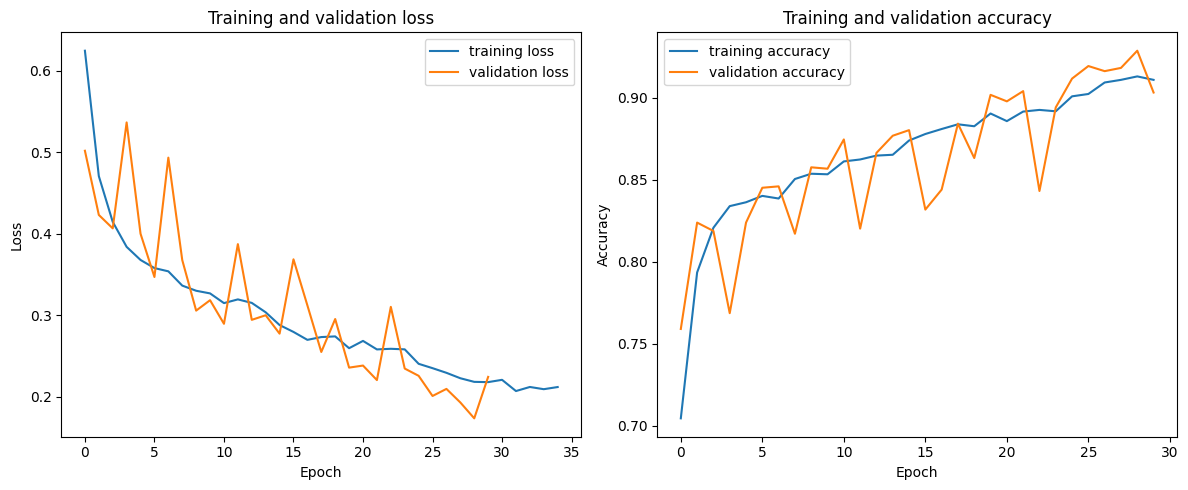

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_combined['loss'], label='training loss')
plt.plot(history_combined['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')

plt.subplot(1, 2, 2)
plt.plot(history_combined['accuracy'], label='training accuracy')
plt.plot(history_combined['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and validation accuracy')

plt.tight_layout()
plt.show()


This step involves evaluating the performance of the trained model on a test dataset that was not used during the training or validation phases. It aims to provide an estimate of how well the model is likely to perform on unseen data. 
1. Making Predictions on the Test Set.
2. Converting Probabilities to Binary Labels.
3. Getting the True Labels.
4. Calculating Accuracy.
5. Generating a Confusion Matrix.
6. Visualizing the Confusion Matrix.

63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step
Dokładność modelu: 92.60%


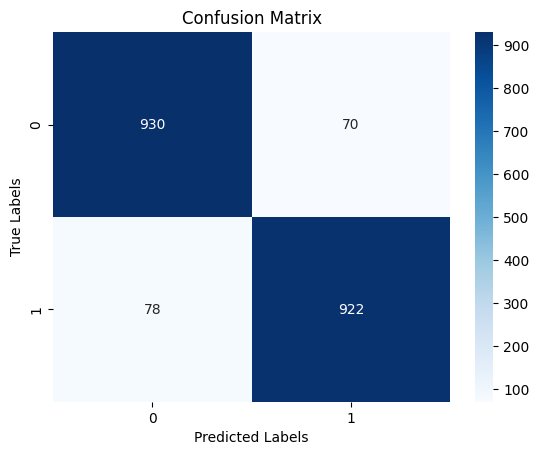

In [21]:

predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes


accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Dokładność modelu: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(true_labels, predicted_labels)


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Grad-CAM (Gradient-weighted Class Activation Mapping)  visualizes which regions of an image are most important for a model's decision.

In [22]:

def get_gradcam_heatmap(model, img_array, layer_name, class_index):
    preds = model.predict(img_array)
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
        conv_layer_output, preds = iterate(np.array(img_array))
        loss = preds[:, class_index]
    
    grads = tape.gradient(loss, conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


This code is designed to visualize Grad-CAM heatmaps for multiple images in a grid format. By using the Grad-CAM technique, we can visually explain the decisions made by the model for a range of images, showing which regions of the image were most influential in the model's prediction. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


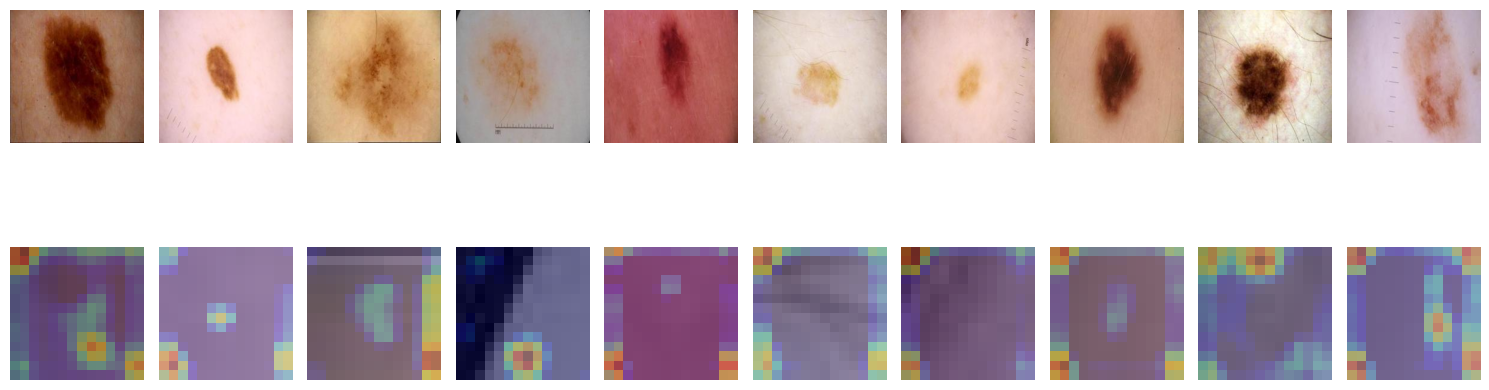

In [14]:
import matplotlib.pyplot as plt


def show_gradcam_for_multiple_images(model, test_generator, true_labels, layer_name, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        img_index = i  
        selected_image = test_generator[0][0][img_index]  
        selected_label = true_labels[img_index]  

        img_array = np.expand_dims(selected_image, axis=0)  

        
        heatmap = get_gradcam_heatmap(model, img_array, layer_name, selected_label)

       
        axes[0, i].imshow(selected_image)
        axes[0, i].axis('off')

      
        axes[1, i].imshow(selected_image)
        axes[1, i].imshow(heatmap, cmap='jet', alpha=0.3)  
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


show_gradcam_for_multiple_images(model, test_generator, true_labels, 'block5_conv3', num_images=10)



Saving the Model

In [23]:

model.save('C:\projekt ML\final_model.keras')
